In [1]:
import sys
from pathlib import Path

# Add project root so `src` becomes importable
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print("Added project root to sys.path:", project_root)

Added project root to sys.path: /home/cowen/mamba-optical-spectra


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
# Import the Coherent modules
from src.data.datasets_coherent import get_coherent_dataloaders
from src.models.bimamba import CoherentBiMamba

/home/cowen/mamba-optical-spectra/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# This notebook visualizes the dramatic difference between "Low Dispersion" and "High Dispersion" optical channels, and demonstrates how the **BiMamba** architecture solves the latter.
# 
# ## 1. The Physics of Dispersion
# Before evaluating the model, we visualize the raw input signals to understand the difficulty of the task.

In [9]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to the two datasets we generated
path_low = Path("../data/coherent_low")
path_high = Path("../data/coherent_high_50k")

Using device: cuda


In [10]:
def get_sample_constellation(data_dir):
    """Helper to grab a single batch and extract I/Q for the first sequence."""
    if not data_dir.exists():
        print(f"Warning: {data_dir} not found.")
        return None, None
        
    loaders = get_coherent_dataloaders(data_dir=data_dir, batch_size=1, num_workers=0)
    inputs, _ = next(iter(loaders["test"]))
    
    # inputs: [1, 2, Seq_Len] -> I=Ch0, Q=Ch1
    I = inputs[0, 0, :].numpy()
    Q = inputs[0, 1, :].numpy()
    return I, Q

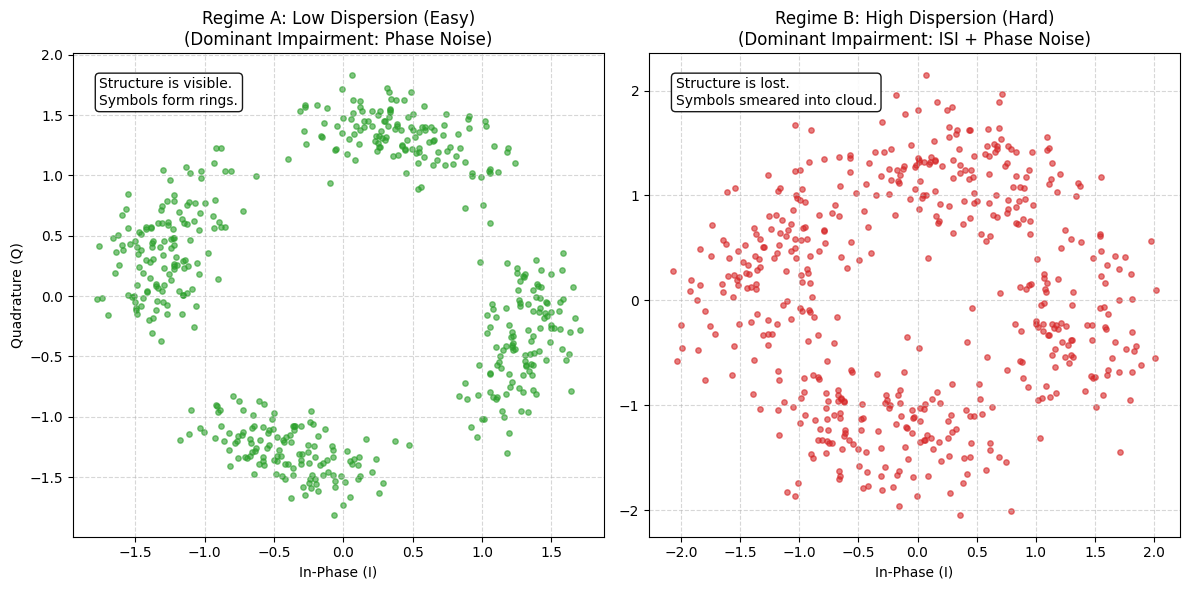

In [11]:
# 2. Visualizing the "Degree of Difficulty"
# We plot Low Dispersion vs. High Dispersion side-by-side.

I_low, Q_low = get_sample_constellation(path_low)
I_high, Q_high = get_sample_constellation(path_high)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Low Dispersion
if I_low is not None:
    axes[0].scatter(I_low, Q_low, alpha=0.6, s=15, c="tab:green", label="Received Signal")
    axes[0].set_title("Regime A: Low Dispersion (Easy)\n(Dominant Impairment: Phase Noise)")
    axes[0].set_xlabel("In-Phase (I)")
    axes[0].set_ylabel("Quadrature (Q)")
    axes[0].grid(True, linestyle="--", alpha=0.5)
    axes[0].text(0.05, 0.95, "Structure is visible.\nSymbols form rings.", 
                 transform=axes[0].transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

# Plot High Dispersion
if I_high is not None:
    axes[1].scatter(I_high, Q_high, alpha=0.6, s=15, c="tab:red", label="Received Signal")
    axes[1].set_title("Regime B: High Dispersion (Hard)\n(Dominant Impairment: ISI + Phase Noise)")
    axes[1].set_xlabel("In-Phase (I)")
    axes[1].grid(True, linestyle="--", alpha=0.5)
    axes[1].text(0.05, 0.95, "Structure is lost.\nSymbols smeared into cloud.", 
                 transform=axes[1].transAxes, verticalalignment='top', 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.show()

# **Physics Analysis:**
# * **Left (Low Disp):** You can see the circular "rings". This distortion is primarily **Phase Noise** (rotation). A standard Mamba (or even a PLL) can track this easily.
# * **Right (High Disp):** The rings are gone. **Chromatic Dispersion** has smeared the energy of each symbol into its neighbors, creating a featureless cloud. This requires a non-causal equalizer (BiMamba) to "desmear" the cloud back into points.

In [12]:
# 3. Loading the BiMamba Solution
# We now apply our best model (BiMamba) to the "Hard" dataset (Regime B).

print("Loading BiMamba model for High Dispersion inference...")

# Re-initialize architecture
model = CoherentBiMamba(
    num_classes=4,
    in_channels=2,
    d_model=64,
    num_layers=6
)

# Load weights
checkpoint_path = Path("../experiments/logs/bimamba/best_bimamba.pt")
if checkpoint_path.exists():
    state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    print("Model weights loaded successfully.")
else:
    print("Checkpoint not found! Running with random weights (results will be garbage).")

model.to(device)
model.eval()

Loading BiMamba model for High Dispersion inference...
Model weights loaded successfully.


CoherentBiMamba(
  (input_proj): Linear(in_features=2, out_features=64, bias=True)
  (layers): ModuleList(
    (0-5): 6 x BiMambaBlock(
      (fwd_mamba): Mamba(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (act): SiLU()
        (x_proj): Linear(in_features=128, out_features=36, bias=False)
        (dt_proj): Linear(in_features=4, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
      )
      (bwd_mamba): Mamba(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (act): SiLU()
        (x_proj): Linear(in_features=128, out_features=36, bias=False)
        (dt_proj): Linear(in_features=4, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
    

In [13]:
# 4. Evaluation on High Dispersion Data
loaders_high = get_coherent_dataloaders(data_dir=path_high, batch_size=128, num_workers=0)
test_loader = loaders_high["test"]

# Get class names
with open(path_high / "metadata.json", "r") as f:
    class_names = json.load(f).get("class_names", ["Q1", "Q2", "Q3", "Q4"])

criterion = nn.CrossEntropyLoss()
test_loss = 0.0
all_targets = []
all_preds = []

with torch.inference_mode():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        logits = model(inputs)
        loss = criterion(logits, targets)
        test_loss += loss.item() * inputs.size(0)

        _, predicted = logits.max(1)
        
        all_targets.append(targets.cpu().numpy().flatten())
        all_preds.append(predicted.cpu().numpy().flatten())

all_targets = np.concatenate(all_targets)
all_preds = np.concatenate(all_preds)
test_acc = (all_preds == all_targets).mean()

print(f"Test Set Accuracy: {test_acc*100:.2f}%")
print(f"Symbol Error Rate: {(1-test_acc)*100:.2f}%")

Test Set Accuracy: 99.26%
Symbol Error Rate: 0.74%


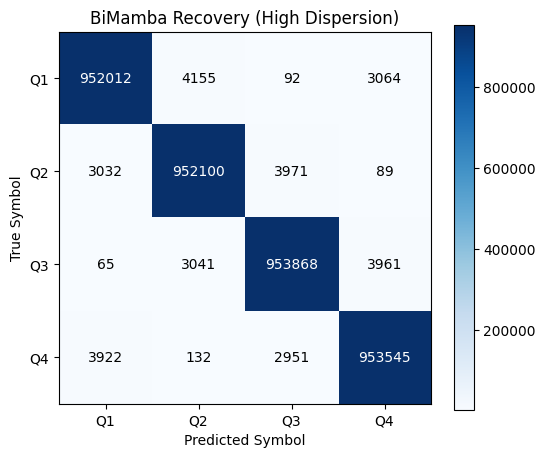

In [14]:
# 5. Confusion Matrix
# Proving that the model recovered distinct symbols from the "Red Cloud" above.

cm = confusion_matrix(all_targets, all_preds)

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(4),
    yticks=np.arange(4),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel="True Symbol",
    xlabel="Predicted Symbol",
    title=f"BiMamba Recovery (High Dispersion)",
)

# Annotate
thresh = cm.max() / 2.0
for i in range(4):
    for j in range(4):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.show()

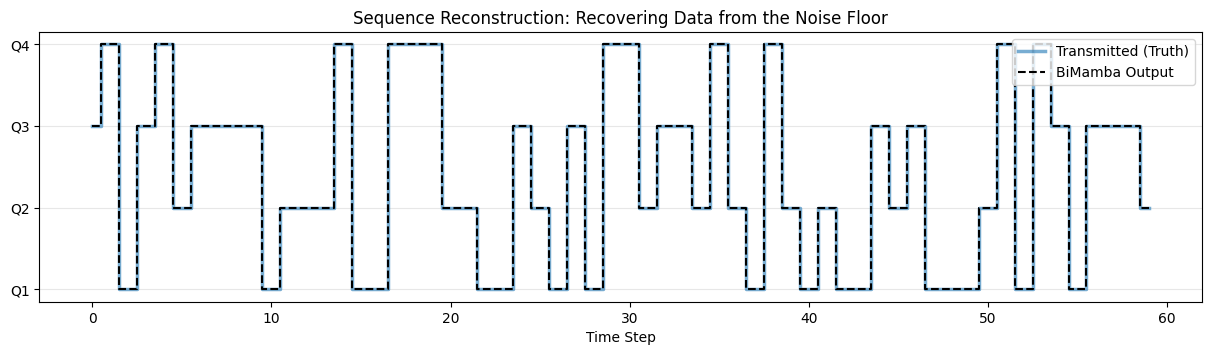

In [15]:
# 6. Sequence Reconstruction Snapshot
# Comparing Truth vs. Prediction for a single sequence slice.

inputs, targets = next(iter(test_loader))
inputs = inputs.to(device)
with torch.inference_mode():
    logits = model(inputs)
    _, predicted = logits.max(1)

# Grab first sample in batch, first 60 time steps
zoom = slice(0, 60)
true_seq = targets[0, zoom].cpu().numpy()
pred_seq = predicted[0, zoom].cpu().numpy()
x_axis = np.arange(len(true_seq))

fig, ax = plt.subplots(figsize=(15, 3.5))
ax.step(x_axis, true_seq, where='mid', label="Transmitted (Truth)", linewidth=2.5, alpha=0.6)
ax.step(x_axis, pred_seq, where='mid', label="BiMamba Output", linestyle="--", linewidth=1.5, color="black")

# Mark errors
errors = np.where(true_seq != pred_seq)[0]
if len(errors) > 0:
    ax.scatter(errors, pred_seq[errors], color='red', label="Error", marker='x', s=100, zorder=5)

ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(class_names)
ax.set_title("Sequence Reconstruction: Recovering Data from the Noise Floor")
ax.set_xlabel("Time Step")
ax.legend(loc="upper right")
ax.grid(True, axis='y', alpha=0.3)
plt.show()

In [16]:
# 7. Save Metrics
metrics = {
    "model": "CoherentBiMamba",
    "dataset": "High Dispersion (50k)",
    "test_acc": float(test_acc),
    "test_loss": float(test_loss / len(test_loader.dataset))
}

metrics_dir = Path("../reports/metrics")
metrics_dir.mkdir(parents=True, exist_ok=True)
with open(metrics_dir / "bimamba_final_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
    
print("Final metrics saved.")

Final metrics saved.
